In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.constants as const
import pandas as pd

In [8]:
file_lst = glob.glob('../../SpinW_data_generation/MATLAB_SpinW/CrI3_data/20221107/*.mat')
print(f"Find {len(file_lst)} files.")

Find 1000 files.


In [9]:
meV_to_2piTHz = 2 * np.pi * 1e-15 / const.physical_constants['hertz-electron volt relationship'][0]

def lorentzian(center, Gamma, intensity, resolution=0.1, minimum=None):
    if minimum is not None:
        w = np.arange(max(0, center-8*Gamma), center+8*Gamma+resolution, resolution)
    else:
        w = np.arange(center-8*Gamma, center+8*Gamma+resolution, resolution)
    l = intensity/np.pi * 0.5*Gamma / ((w-center)**2 + (0.5*Gamma)**2)
    return w, l

In [75]:
data = scipy.io.loadmat(file_lst[1])
q_idx = 0

columns=['S_qt', 'q', 't', 'J1', 'J2', 'J3', 'Jc', 'DM', 'Dz', 'K', 'G']
df_lst = []

for file in file_lst[:100]:
    data = scipy.io.loadmat(file)
    q = data['hkl'][:,q_idx]
    
    w = (data['Evect'].squeeze()[1:] +  data['Evect'].squeeze()[:-1]) / 2
    Sqw = data['swConv'][:,q_idx]

    _, l_filter = lorentzian(center=0, Gamma=0.5, intensity=1, resolution=w[1]-w[0])

    times = np.arange(0,5,0.01) # [ps]
    Sqw_broaden = np.convolve(Sqw, l_filter, mode='same')
    Sqt = np.einsum("wt, w -> wt", np.cos(np.einsum("w, t -> wt", w * meV_to_2piTHz, times)), Sqw_broaden).sum(axis=0)
    Sqt /= Sqt[0]

    df_lst.append(
        [Sqt, q, times] + [np.squeeze(data[_key]) for _key in columns[3:]]
    )

In [76]:
df_save = pd.DataFrame(df_lst, columns=columns)
df_save.head(5)

,S_qt,q,t,J1,J2,J3,Jc,DM,Dz,K,G
0,"[1.0, 0.9841080030047544, 0.9370412460657926, ...","[0.3333333333333333, 0.3333333333333333, 0.0]","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",-2.01,-0.16,0.08,-0.59,-0.31,-0.22,0,0
1,"[1.0, 0.981397474465388, 0.9267210456736912, 0...","[0.3333333333333333, 0.3333333333333333, 0.0]","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",-1.8592820770340746,-0.16,0.08,-0.59,-0.6711857852431973,-0.22,-0.34618797740422635,0
2,"[1.0, 0.9785120982870386, 0.9157832291233033, ...","[0.3333333333333333, 0.3333333333333333, 0.0]","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",-1.7216393416866893,-0.16,0.08,-0.59,-0.9306323973309976,-0.22,-0.721215471378955,0
3,"[1.0, 0.9769063598802843, 0.909414905396127, 0...","[0.3333333333333333, 0.3333333333333333, 0.0]","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",-1.8123796565214432,-0.16,0.08,-0.59,-0.8172347949669688,-0.22,-0.9877681060147137,0
4,"[1.0, 0.9751584096851169, 0.9021775165887902, ...","[0.3333333333333333, 0.3333333333333333, 0.0]","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",-2.27336028235563,-0.16,0.08,-0.59,-0.4651682904031029,-0.22,-0.710515133610435,0


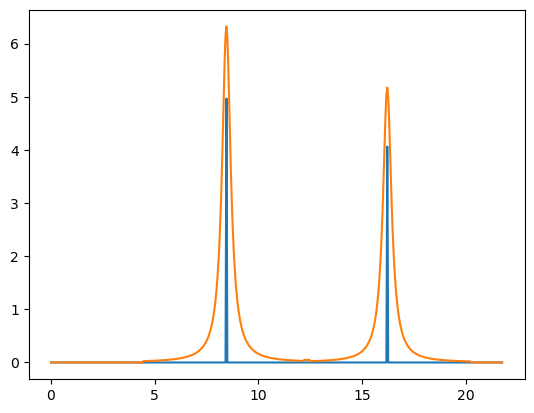

In [77]:
plt.plot(w, Sqw)
plt.plot(w, np.convolve(Sqw, l_filter, mode='same'))

In [78]:
ax.shape

(5, 6)

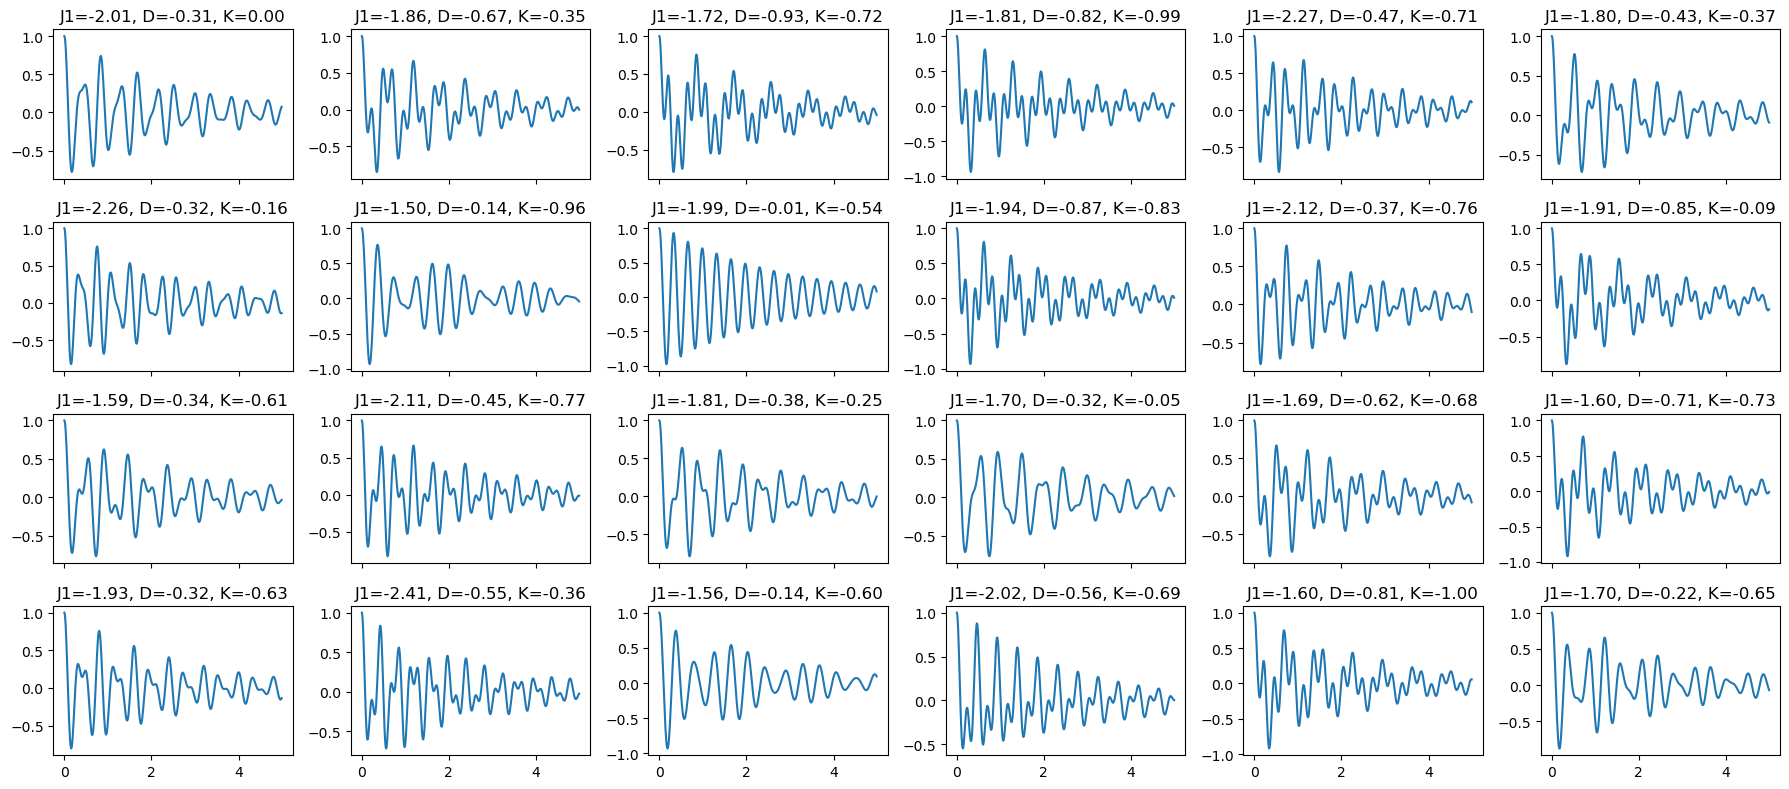

In [83]:
counter = 0
nSqts = 24
ncols = 6
nrows = np.ceil(nSqts / 6).astype('int')
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2*nrows), sharex=True)
for i in range(nSqts):
    ax[i // ncols, i % ncols].plot(df_save.iloc[i]['t'], df_save.iloc[i]['S_qt'])
    ax[i // ncols, i % ncols].set_title(f"J1={df_save.iloc[i]['J1']:.2f}, D={df_save.iloc[i]['DM']:.2f}, K={df_save.iloc[i]['K']:.2f}")
fig.tight_layout()


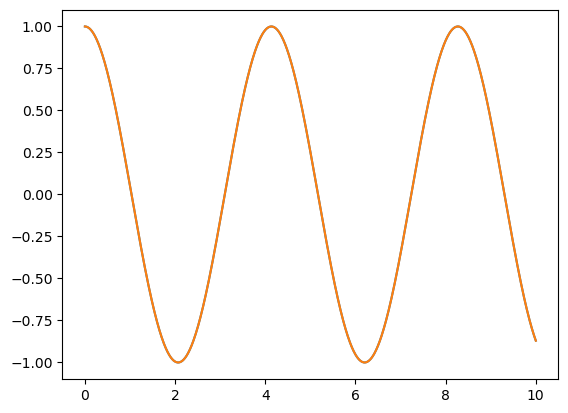

In [12]:
times = np.linspace(0,10,1001)
s1 = np.cos(meV_to_2piTHz * times)
s2 = np.cos(2 * np.pi / 4.13567 * times)
plt.plot(times,s1)
plt.plot(times,s2)